In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Q3)

### Design a genetic algorithm to solve the polynomial fitting problem that we did in Homework #1. You need to implement a genetic algorithm using BOTH mutation AND crossover operations. You need to decide a mutation rate and a crossover rate.  
 
### Plot the following in one figure: 1) the original noisy data, 2) the polynomial you obtained in  Homework  #1,  and  3)  the  polynomial  obtained  from  this  implementation.  Compare  and  discussion the difference in performance of the two polynomials obtained with two different  methods. 

C:\Users\wyatt\AppData\Local\Temp\ipykernel_7892\18227241.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


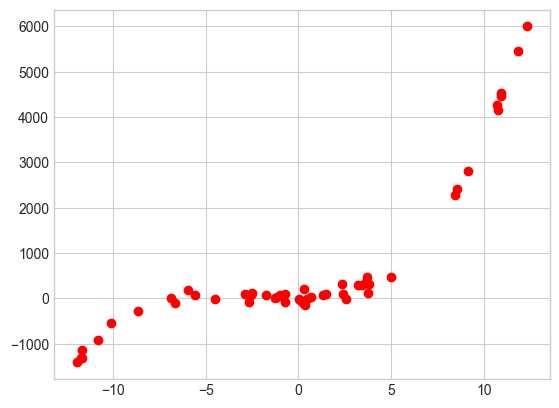

In [2]:
# FROM HW 1
plt.style.use('seaborn-whitegrid') 

noise_scale = 100 
number_of_samples = 50 

x =  25*(np.random.rand(number_of_samples, 1) - 0.5) 
y = 5 * x + 15 * x**2 + 2 * x**3 + noise_scale*np.random.randn(number_of_samples, 1) 

plt.plot(x,y,'ro')

In [3]:
def cubic(x, w):
    
    g = np.array([
        x**0,
        x**1,
        x**2,
        x**3,
    ]).reshape(w.shape[0], -1)
    
    return w @ g
    

In [4]:
class GeneticAlgorithm:
    
    def __init__(
        self, 
        f, 
        x, 
        y_true, 
        M,
        
        population_size, 
        crossover_rate, 
        
        p_organism_mutates,
        p_allele_mutates,

        fitness_threshold,
        max_generations,
    ):
        
        self.coeff_range = 20

        self.f = f
        self.x = x
        self.y_true = y_true
        self.y_true_mean = np.mean(self.y_true)*np.ones_like(y_true)

        self.M = M
        self.N = len(self.y_true)
        
        self.population_size = int(population_size)
        self.crossover_rate = crossover_rate
        
        self.p_organism_mutates = p_organism_mutates
        self.p_allele_mutates = p_allele_mutates
        
        self.selection_size = np.floor(self.crossover_rate*self.population_size)
        
        self.fitness_threshold = fitness_threshold
        self.max_generations = max_generations
        
        self.P = self.create_population(self.population_size)
        self.best_organism = self.arrange_organisms_by_fitness(self.P)[0]
                
    def create_organism(self):
        
        return np.random.uniform(- self.coeff_range, self.coeff_range, size=self.M)
    
    def create_population(self, population_size):
        
        return np.array(
            [
                self.create_organism()
                for organism_num in range(population_size)
            ]
        )
    
    def mutate(self, organism):
        
        num_alleles_to_mutate = int(np.floor(self.p_allele_mutates * self.M))
        mutation_mask = np.array(
            [True]*num_alleles_to_mutate 
            + [False]*(self.M - num_alleles_to_mutate)
        )
        np.random.shuffle(mutation_mask)
        
        for allele_num, perform_mutation in enumerate(mutation_mask):
            
            if perform_mutation:
                
                mutation_strength = np.random.uniform(-self.coeff_range, self.coeff_range) / 2
                organism[allele_num] += mutation_strength
        
        return organism
    
    def crossover(self, parent_organism1, parent_organism2):
        
        assert parent_organism1.shape == parent_organism2.shape
        
        parents = [parent_organism1, parent_organism2]
        
        organism_shape = parent_organism1.shape
        crossover_mask = np.random.choice([-1, 1], size=organism_shape)
        
        child1 = [parents[crossover_mask[i]][i] for i in range(organism_shape[0])]        
        child2 = [parents[-crossover_mask[i]][i] for i in range(organism_shape[0])]        
        
        return child1, child2
        
    def determine_fitness(self, organism):
        
        y_predicted = self.f(self.x, organism)
                
        sum_of_squares_total = (
            (self.y_true_mean - y_predicted) ** 2
        ).flatten().sum()
        
        sum_of_squares_regression = (
            (self.y_true - y_predicted) ** 2
        ).flatten().sum()
        average_error = sum_of_squares_regression / self.N
        coefficient_of_determination = (
            1 - (sum_of_squares_regression / sum_of_squares_total)
        ) * 100
        
        output = {
            'SST': sum_of_squares_total,
            'SSR': sum_of_squares_regression,
            'Average Error': average_error,
            'COD': coefficient_of_determination,
            'Organism': organism,
        }
        
        return output
    
    def arrange_organisms_by_fitness(self, population):
        
        fitnesses = sorted([
            self.determine_fitness(organism)
            for organism in population
        ],
            key=lambda fitness: fitness['Average Error'], reverse=False
        )
        
        return fitnesses
        
    
    def create_new_generation(self, P):
        
        survivors = np.array([
            fitness_rating['Organism'] 
            for fitness_rating in self.arrange_organisms_by_fitness(P)[:int(self.selection_size)]
        ])
        
        parents = np.array(
            [
                survivors[np.random.randint(0, survivors.shape[0],2)]
                for parent_pair_num in range(int(np.floor(self.population_size/2)))
            ]
        )
        
        offspring = np.array(
            [
                child 
                for parent_pair in parents
                for child in self.crossover(*parent_pair)

            ]
        )
        
        num_mutants = int(np.floor(self.p_organism_mutates * self.M))
        mutation_decision_mask = np.array(
            [True]*num_mutants 
            + [False]*(self.population_size - num_mutants)
        )
        np.random.shuffle(mutation_decision_mask)
        
        for mutant_num, perform_mutation in enumerate(mutation_decision_mask):
            
            if perform_mutation:
                offspring[mutant_num] = self.mutate(offspring[mutant_num])
        
        return offspring
        
    def evolve(self):
        
        terminate = lambda best_organism, generation_count: best_organism['COD'] >= self.fitness_threshold or generation_count >= self.max_generations
        
        P = self.P
        generation_count = 0
        best_organism = self.arrange_organisms_by_fitness(P)[0]
        
        while not terminate(best_organism, generation_count):
             
#             print(
#                 'Generation #%i/%i (%1.2f%%):\n' 
#                 '| Best Organism: %s \n'
#                 '| Average Error: %1.3e \n'
#                 '| Population shape: %s \n'
#                 '| %s'% (
#                     generation_count, 
#                     self.max_generations, 
#                     (generation_count/self.max_generations) * 100,
#                     str(best_organism['Organism']), 
#                     best_organism['Average Error'],
#                     P.shape,
#                     '=='*25,
#                 ), end='\n\n'
#             )
            
            P = self.create_new_generation(P)
            best_organism = self.arrange_organisms_by_fitness(P)[0]
           
            generation_count += 1
            
        return best_organism
            

In [5]:
crossover_rate = 0.1
population_size = 5e4

p_allele_mutates = 0.4
p_organism_mutates = 0.5

fitness_threshold = 0.98
max_generations = 500

GA = GeneticAlgorithm(
    cubic, 
    x, 
    y, 
    4, 
    population_size=population_size,
    crossover_rate=crossover_rate, 
    p_organism_mutates=p_organism_mutates,
    p_allele_mutates=p_allele_mutates,
    fitness_threshold=fitness_threshold,
    max_generations=max_generations,
)

In [6]:
# GA.arrange_organisms_by_fitness(GA.P)

In [7]:
best_organism = GA.evolve()

In [8]:
# Predicted values from HW 1:
hw1_w = np.array([-28.11452636,   2.06279237,  15.3246926,    2.03888255])

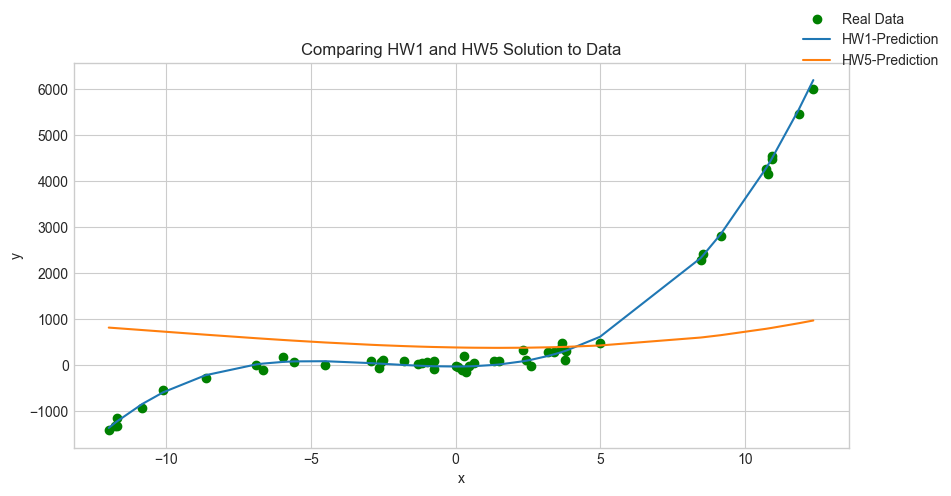

In [12]:
sorted_x = np.array(sorted(x))

hw1_predicted = cubic(sorted_x, hw1_w)
hw5_predicted = cubic(sorted_x, best_organism['Organism'])

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.scatter(x, y, label='Real Data', color='green')
axs.plot(sorted_x, hw1_predicted, label='HW1-Prediction')
axs.plot(sorted_x, hw5_predicted, label='HW5-Prediction')

axs.set_title('Comparing HW1 and HW5 Solution to Data')
axs.set_xlabel('x')
axs.set_ylabel('y')

fig.legend()


## Not only does the genetic algorithm take significantly longer than the the polyfit function to train-- it also does not perform as well.